<a href="https://colab.research.google.com/github/JamionW/Advanced-Analysis-of-Algorithms/blob/master/Combinatorial_Inverse_Elasticity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# This is the Master Code Notebook for Inverse Elasticity

### Necessary libraries

In [19]:
import pandas as pd
import geopandas as gpd
import networkx as nx
import pyproj
from shapely.geometry import Point, LineString
from shapely.ops import nearest_points, transform
import fiona
from scipy.spatial import cKDTree
from joblib import Parallel, delayed
from functools import lru_cache
from typing import Dict, List, Tuple
import numpy as np
import logging
import matplotlib.pyplot as plt
import seaborn as sns

### Dataset Imports and Set Coordinate Systems

In [20]:
def import_data(address_file, svi_file, roads_file):
    """
    Import address, SVI, and roads data from specified files.

    Parameters:
    -----------
    address_file : str
        Path to the address GeoJSON file.
    svi_file : str
        Path to the SVI geodatabase file.
    roads_file : str
        Path to the roads shapefile.

    Returns:
    --------
    tuple
        A tuple containing (address_df, svi_df, roads_df)
    """
    print("Importing data...")

    # Import addresses
    print("Importing addresses...")
    address_df = gpd.read_file(address_file)
    print(f"Imported {len(address_df)} addresses.")

    # Import SVI data
    print("Importing SVI data...")
    svi_df = gpd.read_file(svi_file, layer='SVI2022_TENNESSEE_tract')
    print(f"Imported SVI data for {len(svi_df)} tracts.")

    # Import roads
    print("Importing roads...")
    with fiona.open(roads_file) as collection:
        roads_df = gpd.GeoDataFrame.from_features(collection)
    print(f"Imported {len(roads_df)} road segments.")

    return address_df, svi_df, roads_df

In [21]:
def set_crs(address_df, svi_df, roads_df, target_crs="EPSG:32618"):
    """
    Set the Coordinate Reference System (CRS) for all datasets.

    Parameters:
    -----------
    address_df : gpd.GeoDataFrame
        GeoDataFrame containing address data.
    svi_df : gpd.GeoDataFrame
        GeoDataFrame containing SVI data.
    roads_df : gpd.GeoDataFrame
        GeoDataFrame containing roads data.
    target_crs : str, optional
        The target CRS to set for all datasets (default is "EPSG:32618" for UTM zone 18N).

    Returns:
    --------
    tuple
        A tuple containing (address_df, svi_df, roads_df) with updated CRS.
    """
    print(f"Setting CRS to {target_crs} for all datasets...")

    roads_df = roads_df.set_crs(target_crs)
    address_df = address_df.to_crs(target_crs)
    svi_df = svi_df.to_crs(target_crs)

    print(f"Roads CRS: {roads_df.crs}")
    print(f"Addresses CRS: {address_df.crs}")
    print(f"SVI CRS: {svi_df.crs}")

    return address_df, svi_df, roads_df

In [22]:
# Define file paths
address_file = '/content/drive/MyDrive/Colab Notebooks/data/chattanooga.geojson'
svi_file = "/content/drive/MyDrive/Colab Notebooks/data/SVI2022_TENNESSEE_tract.gdb"
roads_file = '/content/drive/MyDrive/Colab Notebooks/data/tl_2023_47065_roads.shp'

# Import data
address_df, svi_df, roads_df = import_data(address_file, svi_file, roads_file)

# Set CRS
address_df, svi_df, roads_df = set_crs(address_df, svi_df, roads_df)

Importing data...
Importing addresses...
Imported 102761 addresses.
Importing SVI data...
Imported SVI data for 1701 tracts.
Importing roads...
Imported 13778 road segments.
Setting CRS to EPSG:32618 for all datasets...
Roads CRS: EPSG:32618
Addresses CRS: EPSG:32618
SVI CRS: EPSG:32618


### Graph Creation

In [23]:
def create_graph_from_roads(roads_gdf: gpd.GeoDataFrame) -> nx.Graph:
    """
    Create a NetworkX graph from a GeoDataFrame of road geometries.

    This function iterates through the geometries in the provided GeoDataFrame
    and creates a graph where each road segment is represented as an edge.

    Parameters:
    -----------
    roads_gdf : gpd.GeoDataFrame
        A GeoDataFrame containing road geometries. Each row should represent
        a road segment with a 'geometry' column containing either LineString
        or MultiLineString objects.

    Returns:
    --------
    nx.Graph
        A NetworkX graph representation of the road network. Each edge in the
        graph corresponds to a road segment and includes 'geometry' and 'length'
        attributes.

    Notes:
    ------
    - For LineString geometries, a single edge is added to the graph.
    - For MultiLineString geometries, multiple edges are added, one for each
      component LineString.
    - The 'geometry' attribute of each edge is set to the corresponding
      LineString object.
    - The 'length' attribute of each edge is set to the length of the
      corresponding LineString.
    """
    G = nx.Graph()

    for idx, row in roads_gdf.iterrows():
        if row.geometry.geom_type == 'LineString':
            start = row.geometry.coords[0]
            end = row.geometry.coords[-1]
            G.add_edge(start, end, geometry=row.geometry, length=row.geometry.length)
        elif row.geometry.geom_type == 'MultiLineString':
            for line in row.geometry:
                start = line.coords[0]
                end = line.coords[-1]
                G.add_edge(start, end, geometry=line, length=line.length)

    return G

In [24]:
def add_edge_lengths(G):
    """
    Add length attribute to edges if missing.

    Parameters:
    -----------
    G : networkx.Graph
        The input graph.

    Returns:
    --------
    networkx.Graph
        The graph with edge lengths added.
    """
    for u, v, data in G.edges(data=True):
        if 'length' not in data:
            data['length'] = np.sqrt(
                (G.nodes[u]['pos'][0] - G.nodes[v]['pos'][0])**2 +
                (G.nodes[u]['pos'][1] - G.nodes[v]['pos'][1])**2
            )
    return G

In [25]:
def project_graph(G, source_crs='EPSG:4326', target_crs='EPSG:32618'):
    """
    Project the graph from one coordinate system to another.

    Parameters:
    -----------
    G : networkx.Graph
        The input graph.
    source_crs : str, optional
        The source coordinate reference system (default is 'EPSG:4326' for WGS84).
    target_crs : str, optional
        The target coordinate reference system (default is 'EPSG:32618' for UTM zone 18N).

    Returns:
    --------
    networkx.Graph
        The projected graph.
    """
    # Define the transformation
    source = pyproj.CRS(source_crs)
    target = pyproj.CRS(target_crs)
    project = pyproj.Transformer.from_crs(source, target, always_xy=True).transform

    # Project the graph
    G_projected = G.copy()
    for node in G_projected.nodes():
        point = transform(project, Point(node))
        G_projected.nodes[node]['pos'] = (point.x, point.y)

    for u, v, data in G_projected.edges(data=True):
        point1 = Point(G_projected.nodes[u]['pos'])
        point2 = Point(G_projected.nodes[v]['pos'])
        data['length'] = point1.distance(point2)

    return G_projected

In [26]:
# Create the graph
G = create_graph_from_roads(roads_df)
print(f"Created graph with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges")

# Add edge lengths if missing
G = add_edge_lengths(G)

# Project the graph
G_projected = project_graph(G)

# Use G_projected for further calculations

Created graph with 21154 nodes and 13225 edges


# Euclidean Elasticity with Decay

### Network Elasticity with Decay

In [27]:
def calculate_euclidean_inverse_elasticity(
    target_area_data: gpd.GeoDataFrame,
    point_gdf: gpd.GeoDataFrame,
    area_index_gdf: gpd.GeoDataFrame,
    lambda_param: float = 0.001,
    beta: float = 1,
    index_column: str = 'RPL_THEMES',
    area_id_column: str = 'FIPS'
) -> pd.DataFrame:
    """
    Calculate Euclidean inverse elasticity between points and neighboring areas.

    Parameters:
    -----------
    target_area_data : gpd.GeoDataFrame
        GeoDataFrame containing the target area data.
    point_gdf : gpd.GeoDataFrame
        GeoDataFrame containing point data.
    area_index_gdf : gpd.GeoDataFrame
        GeoDataFrame containing area index data.
    lambda_param : float, optional
        Decay parameter (default is 0.001).
    beta : float, optional
        Exponent for index difference sensitivity (default is 1).
    index_column : str, optional
        Name of the column containing index values (default is 'RPL_THEMES').
    area_id_column : str, optional
        Name of the column containing area identifiers (default is 'FIPS').

    Returns:
    --------
    pd.DataFrame
        DataFrame containing the calculated inverse elasticities.
    """
    print("Starting calculate_euclidean_inverse_elasticity")
    print(f"Points in point_gdf: {len(point_gdf)}")

    target_geometry = target_area_data.geometry
    print(f"Target area size: {target_geometry.area}")

    points_within = point_gdf[point_gdf.geometry.within(target_geometry)]
    print(f"Points within target area: {len(points_within)}")

    neighboring_areas = area_index_gdf[area_index_gdf.geometry.touches(target_geometry)]
    print(f"Number of neighboring areas: {len(neighboring_areas)}")

    results = []
    for _, point in points_within.iterrows():
        point_geom = point.geometry if hasattr(point, 'geometry') else point['geometry']
        point_id = point.Index if hasattr(point, 'Index') else (point.name if hasattr(point, 'name') else point['id'])

        for _, neighbor_area in neighboring_areas.iterrows():
            nearest_point = nearest_points(point_geom, neighbor_area.geometry)[1]
            distance = point_geom.distance(nearest_point)

            target_index = target_area_data[index_column]
            neighbor_index = neighbor_area[index_column]
            index_difference = abs(target_index - neighbor_index)

            if index_difference == 0:
                inverse_elasticity = float('inf')
            else:
                inverse_elasticity = np.exp(-lambda_param * distance) / (index_difference ** beta)

            results.append({
                'target_area': target_area_data[area_id_column],
                'point_id': point_id,
                'neighbor_area': neighbor_area[area_id_column],
                'distance_euclidean': distance,
                'inverse_elasticity_euclidean': inverse_elasticity
            })

    print(f"Total results calculated: {len(results)}")
    return pd.DataFrame(results)

In [28]:
# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

def calculate_network_inverse_elasticity(
    G: nx.Graph,
    target_area_data: gpd.GeoDataFrame,
    point_gdf: gpd.GeoDataFrame,
    area_index_gdf: gpd.GeoDataFrame,
    euclidean_results: pd.DataFrame,
    lambda_param: float = 0.001,
    beta: float = 1,
    index_column: str = 'RPL_THEMES',
    area_id_column: str = 'FIPS'
) -> pd.DataFrame:
    """
    Calculate network inverse elasticity between points and neighboring areas.

    Parameters:
    -----------
    G : nx.Graph
        NetworkX graph representing the road network.
    target_area_data : gpd.GeoDataFrame
        GeoDataFrame containing the target area data.
    point_gdf : gpd.GeoDataFrame
        GeoDataFrame containing point data.
    area_index_gdf : gpd.GeoDataFrame
        GeoDataFrame containing area index data.
    euclidean_results : pd.DataFrame
        DataFrame containing Euclidean distance results.
    lambda_param : float, optional
        Decay parameter (default is 0.001).
    beta : float, optional
        Exponent for index difference sensitivity (default is 1).
    index_column : str, optional
        Name of the column containing index values (default is 'RPL_THEMES').
    area_id_column : str, optional
        Name of the column containing area identifiers (default is 'FIPS').

    Returns:
    --------
    pd.DataFrame
        DataFrame containing the calculated network inverse elasticities.
    """
    logging.info("Starting calculate_network_inverse_elasticity")
    target_geometry = target_area_data.geometry
    points_within = point_gdf[point_gdf.geometry.within(target_geometry)].copy()
    neighboring_areas = area_index_gdf[area_index_gdf.geometry.touches(target_geometry)]

    logging.info(f"Points within target area: {len(points_within)}")
    logging.info(f"Number of neighboring areas: {len(neighboring_areas)}")

    if 'point_id' not in points_within.columns:
        logging.warning("'point_id' column not found. Using index as point_id.")
        points_within['point_id'] = points_within.index

    node_coords = np.array([(data['pos'][0], data['pos'][1]) for _, data in G.nodes(data=True)])
    node_tree = cKDTree(node_coords)

    def find_nearest_node(point):
        _, index = node_tree.query([point.x, point.y])
        return list(G.nodes())[index]

    euclidean_distances = {
        (row['point_id'], row['neighbor_area']): row['distance_euclidean']
        for _, row in euclidean_results.iterrows()
    }

    results = []
    for _, row in points_within.iterrows():
        point_id = row['point_id']
        point_geom = row.geometry

        try:
            point_node = find_nearest_node(point_geom)
        except Exception as e:
            logging.error(f"Error finding nearest node for point_id {point_id}: {str(e)}")
            continue

        for _, neighbor_area in neighboring_areas.iterrows():
            try:
                nearest_point_on_neighbor = nearest_points(point_geom, neighbor_area.geometry)[1]
                neighbor_node = find_nearest_node(nearest_point_on_neighbor)

                euclidean_distance = euclidean_distances.get((point_id, neighbor_area[area_id_column]))
                if euclidean_distance is None:
                    logging.warning(f"No Euclidean distance found for point_id {point_id} and neighbor area {neighbor_area[area_id_column]}")
                    continue

                heuristic = lambda u, v: euclidean_distance

                try:
                    network_distance = nx.astar_path_length(G, point_node, neighbor_node, heuristic, weight='length')
                    used_euclidean_fallback = False
                except nx.NetworkXNoPath:
                    network_distance = euclidean_distance
                    used_euclidean_fallback = True

                index_difference = abs(target_area_data[index_column] - neighbor_area[index_column])

                if index_difference == 0:
                    inverse_elasticity = float('inf')
                else:
                    inverse_elasticity = np.exp(-lambda_param * network_distance) / (index_difference ** beta)

                results.append({
                    'target_area': target_area_data[area_id_column],
                    'point_id': point_id,
                    'neighbor_area': neighbor_area[area_id_column],
                    'network_distance': network_distance,
                    'inverse_elasticity_network': inverse_elasticity,
                    'used_euclidean_fallback': used_euclidean_fallback
                })

            except Exception as e:
                logging.error(f"Error processing neighbor area {neighbor_area[area_id_column]} for point_id {point_id}: {str(e)}")

    logging.info(f"Completed network inverse elasticity calculation. Total results: {len(results)}")
    return pd.DataFrame(results)

#Combine Elasticities

In [29]:
def combine_elasticities_and_calculate_weighted_index(network_df, euclidean_df, area_index_gdf, network_weight=0.7, index_column='RPL_THEMES', area_id_column='FIPS'):
    print(f"Starting combine_elasticities_and_calculate_weighted_index")
    print(f"Network df shape: {network_df.shape}, Euclidean df shape: {euclidean_df.shape}")

    if network_df.empty:
        print("Warning: Network DataFrame is empty. Proceeding with Euclidean results only.")
        combined_df = euclidean_df.copy()
        combined_df['combined_inverse_elasticity'] = combined_df['inverse_elasticity_euclidean']
        combined_df['combined_distance'] = combined_df['distance_euclidean']
    else:
        # Merge the two DataFrames
        combined_df = pd.merge(euclidean_df, network_df,
                               on=['target_area', 'neighbor_area', 'point_id'],
                               how='left')
        print(f"Combined df shape after merge: {combined_df.shape}")

        # Check for any rows where network data is missing
        network_nulls = combined_df[combined_df['network_distance'].isnull()]
        print(f"Rows missing network data: {len(network_nulls)}")

        # Calculate combined inverse elasticity and distance
        euclidean_weight = 1 - network_weight
        combined_df['combined_inverse_elasticity'] = np.where(
            combined_df['inverse_elasticity_network'].isnull(),
            combined_df['inverse_elasticity_euclidean'],
            network_weight * combined_df['inverse_elasticity_network'] + euclidean_weight * combined_df['inverse_elasticity_euclidean']
        )
        combined_df['combined_distance'] = np.where(
            combined_df['network_distance'].isnull(),
            combined_df['distance_euclidean'],
            network_weight * combined_df['network_distance'] + euclidean_weight * combined_df['distance_euclidean']
        )

    # Prepare for weighted index calculation
    target_indices = area_index_gdf.set_index(area_id_column)[index_column]
    combined_df['target_index'] = combined_df['target_area'].map(target_indices)
    combined_df['neighbor_index'] = combined_df['neighbor_area'].map(target_indices)

    # Calculate weights
    grouped = combined_df.groupby('point_id')
    total_weights = grouped['combined_inverse_elasticity'].transform('sum')
    combined_df['weight'] = combined_df['combined_inverse_elasticity'] / total_weights

    # Calculate weighted index difference for each point-neighbor combination
    combined_df['weighted_diff'] = (combined_df['neighbor_index'] - combined_df['target_index']) * combined_df['weight']

    # Aggregate the results
    weighted_index_df = grouped.agg({
        'target_area': 'first',
        'target_index': 'first',
        'weighted_diff': 'sum',
    }).reset_index()

    weighted_index_df['neighbor_count'] = grouped.size().values
    weighted_index_df['weighted_index'] = weighted_index_df['target_index'] + weighted_index_df['weighted_diff']

    print(f"Final weighted index df shape: {weighted_index_df.shape}")
    print(f"Number of unique point_ids: {weighted_index_df['point_id'].nunique()}")
    print(f"Distribution of number of neighboring areas per point:")
    print(weighted_index_df['neighbor_count'].describe())

    return weighted_index_df[['target_area', 'weighted_index']]

#Processing by Tract

In [30]:
def process_target_area(target_area, area_index_gdf, point_gdf, G, lambda_param=0.001, beta=1, network_weight=0.7, index_column='RPL_THEMES', area_id_column='FIPS'):
    print(f"Starting combined process for target area: {target_area}")

    target_area_data = area_index_gdf[area_index_gdf[area_id_column] == target_area].iloc[0]

    # Calculate Euclidean-based inverse elasticity first
    euclidean_result = calculate_euclidean_inverse_elasticity(target_area_data, point_gdf, area_index_gdf, lambda_param, beta, index_column, area_id_column)

    # Calculate network-based inverse elasticity using Euclidean results as heuristics
    network_result = calculate_network_inverse_elasticity(G, target_area_data, point_gdf, area_index_gdf, euclidean_result, lambda_param, beta, index_column, area_id_column)

    # Ensure both results have a 'target_area' column
    if 'target_area' not in network_result.columns:
        network_result['target_area'] = target_area
    if 'target_area' not in euclidean_result.columns:
        euclidean_result['target_area'] = target_area

    # Combine the results and calculate weighted index
    combined_result = combine_elasticities_and_calculate_weighted_index(
        network_result, euclidean_result, area_index_gdf, network_weight, index_column, area_id_column
    )

    print(f"Rows in combined result: {len(combined_result)}")

    return combined_result


# Execution Step

*   Increase lambda_param to make the influence decay more quickly
with distance.
*   Decrease lambda_param to allow influence to extend further.
*   Increase beta to make the function more sensitive to SVI differences.
*   Decrease beta to make the function less sensitive to SVI differences.


---

As the network_weight increases (approaches 1):

More weight is given to the network-based distance and inverse elasticity calculations.

Less weight is given to the Euclidean-based calculations.

So:

When network_weight = 1: The result is based entirely on network distance (road network).

When network_weight = 0: The result is based entirely on Euclidean distance (straight-line).

When network_weight = 0.7 (as in the example): The result is 70% influenced by network distance and 30% by Euclidean distance.

---

target_area: The specific area you're analyzing

svi_df: Your DataFrame containing SVI (Social Vulnerability Index) data

address_df: Your DataFrame containing address point data

G_projected: Your projected NetworkX graph object

lambda_param: The decay parameter

beta: The exponent for index difference sensitivity

network_weight: The weight given to network-based calculations vs. Euclidean-based calculations

index_column: The name of the column containing the index values (SVI in this case)

area_id_column: The name of the column containing area identifiers

In [31]:
# Usage
target_area = '47065000600'  # Hamilton County
#target_area = '47065011314' # smaller, for testing
lambda_param = 0.0015
beta = 0.96
network_weight = 0.7

combined_result_df = process_target_area(
    target_area,
    svi_df,
    address_df,
    G_projected,
    lambda_param,
    beta,
    network_weight,
    index_column='RPL_THEMES',
    area_id_column='FIPS'
)

Starting combined process for target area: 47065000600
Starting calculate_euclidean_inverse_elasticity
Points in point_gdf: 102761
Target area size: 3281659.3943457245
Points within target area: 2096
Number of neighboring areas: 5


Total results calculated: 10480
Starting combine_elasticities_and_calculate_weighted_index
Network df shape: (10480, 6), Euclidean df shape: (10480, 5)
Combined df shape after merge: (10480, 8)
Rows missing network data: 0
Final weighted index df shape: (2096, 6)
Number of unique point_ids: 2096
Distribution of number of neighboring areas per point:
count    2096.0
mean        5.0
std         0.0
min         5.0
25%         5.0
50%         5.0
75%         5.0
max         5.0
Name: neighbor_count, dtype: float64
Rows in combined result: 2096


# Index combination with elasticity set

In [32]:
def combine_and_compare_svi(combined_result_df, address_df, svi_df):
    """
    Combines the calculated weighted index with the original address data and compares it to the tract-level SVI.

    Parameters:
    combined_result_df (pd.DataFrame): Result from process_target_area function
    address_df (pd.DataFrame): Original address DataFrame
    svi_df (pd.DataFrame): Original SVI DataFrame

    Returns:
    pd.DataFrame: DataFrame with address-level and tract-level SVI, and their difference
    """
    # Join the calculated weighted index to the original address DataFrame
    address_df_with_svi = address_df.join(combined_result_df, how='left')

    # Join the census tract SVI to the address_df_with_svi
    address_df_with_both_svi = address_df_with_svi.merge(
        svi_df[['FIPS', 'RPL_THEMES']],
        left_on='target_area',
        right_on='FIPS',
        how='left'
    )

    # Rename the columns for clarity
    address_df_with_both_svi = address_df_with_both_svi.rename(columns={
        'weighted_index': 'address_level_svi',
        'RPL_THEMES': 'tract_level_svi'
    })

    # Calculate the difference between the two SVI measures
    address_df_with_both_svi['svi_difference'] = address_df_with_both_svi['address_level_svi'] - address_df_with_both_svi['tract_level_svi']

    return address_df_with_both_svi

# Usage
result_df = combine_and_compare_svi(combined_result_df, address_df, svi_df)

# Print the head of the resulting DataFrame
print("\nFinal result:")
print(result_df[['address_level_svi', 'tract_level_svi', 'svi_difference']].head())


Final result:
   address_level_svi  tract_level_svi  svi_difference
0           0.231332           0.2457       -0.014368
1           0.242251           0.2457       -0.003449
2           0.287602           0.2457        0.041902
3           0.350348           0.2457        0.104648
4           0.199029           0.2457       -0.046671


# Validation

In [33]:
def validate_svi_results(result_df: gpd.GeoDataFrame, output_dir: str = None):
    """
    Validate and visualize the SVI (Social Vulnerability Index) results.

    This function generates summary statistics and creates visualizations
    to help validate and understand the SVI differences between address-level
    and tract-level calculations.

    Parameters:
    -----------
    result_df : gpd.GeoDataFrame
        A GeoDataFrame containing the results of SVI calculations. It should
        have columns 'svi_difference', 'address_level_svi', and 'tract_level_svi'.
    output_dir : str, optional
        Directory to save the output plots. If None, plots will be displayed
        but not saved.

    Returns:
    --------
    dict
        A dictionary containing summary statistics of SVI differences.

    Notes:
    ------
    This function creates three visualizations:
    1. A histogram of SVI differences
    2. A histogram of address-level SVI with tract-level SVI marked
    3. A choropleth map of address-level SVI within the census tract
    """
    # Calculate summary statistics
    summary_stats = result_df['svi_difference'].describe()
    print("\nSummary statistics of SVI difference:")
    print(summary_stats)

    # Create a histogram of the SVI differences
    plt.figure(figsize=(10, 6))
    sns.histplot(result_df['svi_difference'], kde=True)
    plt.title('Distribution of Differences between Address-level and Tract-level SVI')
    plt.xlabel('SVI Difference (Address - Tract)')
    plt.ylabel('Count')
    if output_dir:
        plt.savefig(f"{output_dir}/svi_difference_histogram.png")
    plt.show()

    # Create a histogram of address-level SVI with tract-level SVI marked
    plt.figure(figsize=(10, 6))
    plt.hist(result_df['address_level_svi'], bins=30, edgecolor='black')
    plt.axvline(result_df['tract_level_svi'].iloc[0], color='r', linestyle='dashed', linewidth=2)
    plt.title('Distribution of Address-level SVI')
    plt.xlabel('SVI')
    plt.ylabel('Count')
    plt.legend(['Tract-level SVI', 'Address-level SVI'])
    if output_dir:
        plt.savefig(f"{output_dir}/address_level_svi_histogram.png")
    plt.show()

    # Create a choropleth map of address-level SVI within the census tract
    fig, ax = plt.subplots(figsize=(15, 15))
    result_df.plot(column='address_level_svi', cmap='YlOrRd',
                   legend=True, ax=ax, legend_kwds={'label': 'Address-level SVI'})
    plt.title('Address-level SVI within Census Tract')
    plt.axis('off')
    if output_dir:
        plt.savefig(f"{output_dir}/address_level_svi_map.png")
    plt.show()

    return summary_stats.to_dict()


Summary statistics of SVI difference:
count    2096.000000
mean        0.065523
std         0.067314
min        -0.060738
25%         0.008932
50%         0.067646
75%         0.126881
max         0.177686
Name: svi_difference, dtype: float64


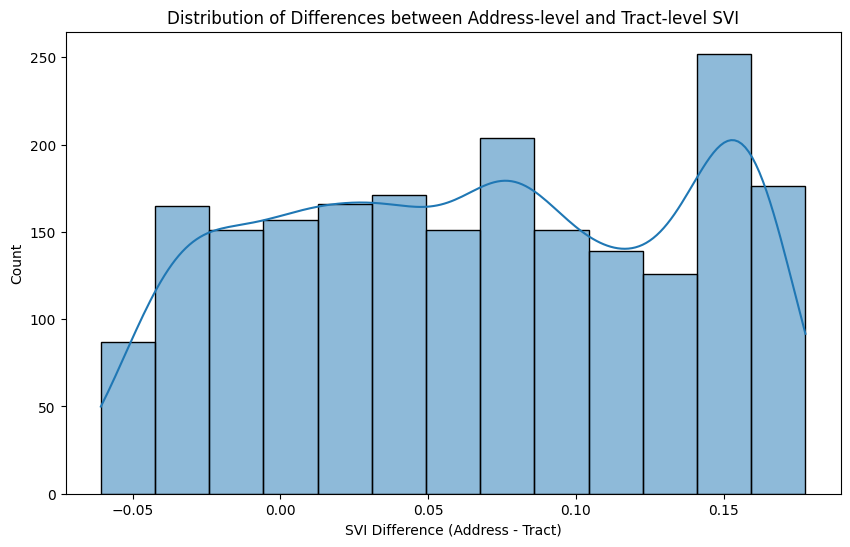

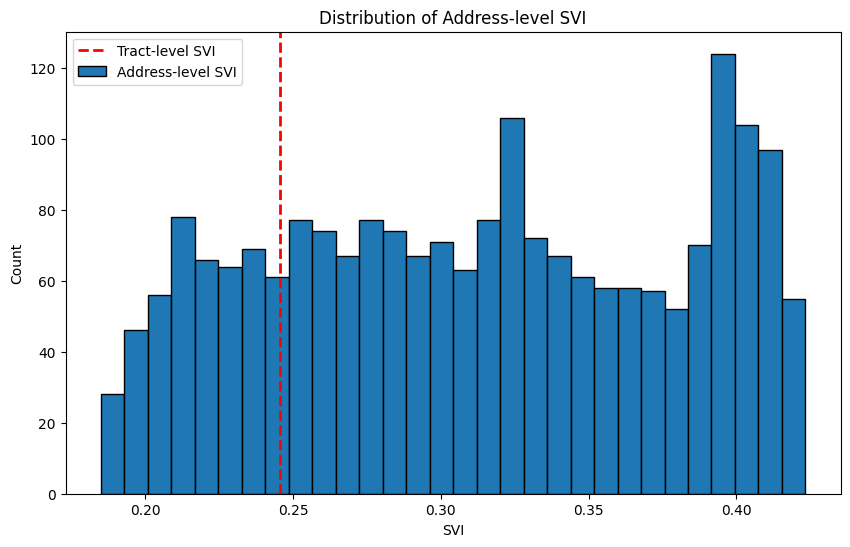

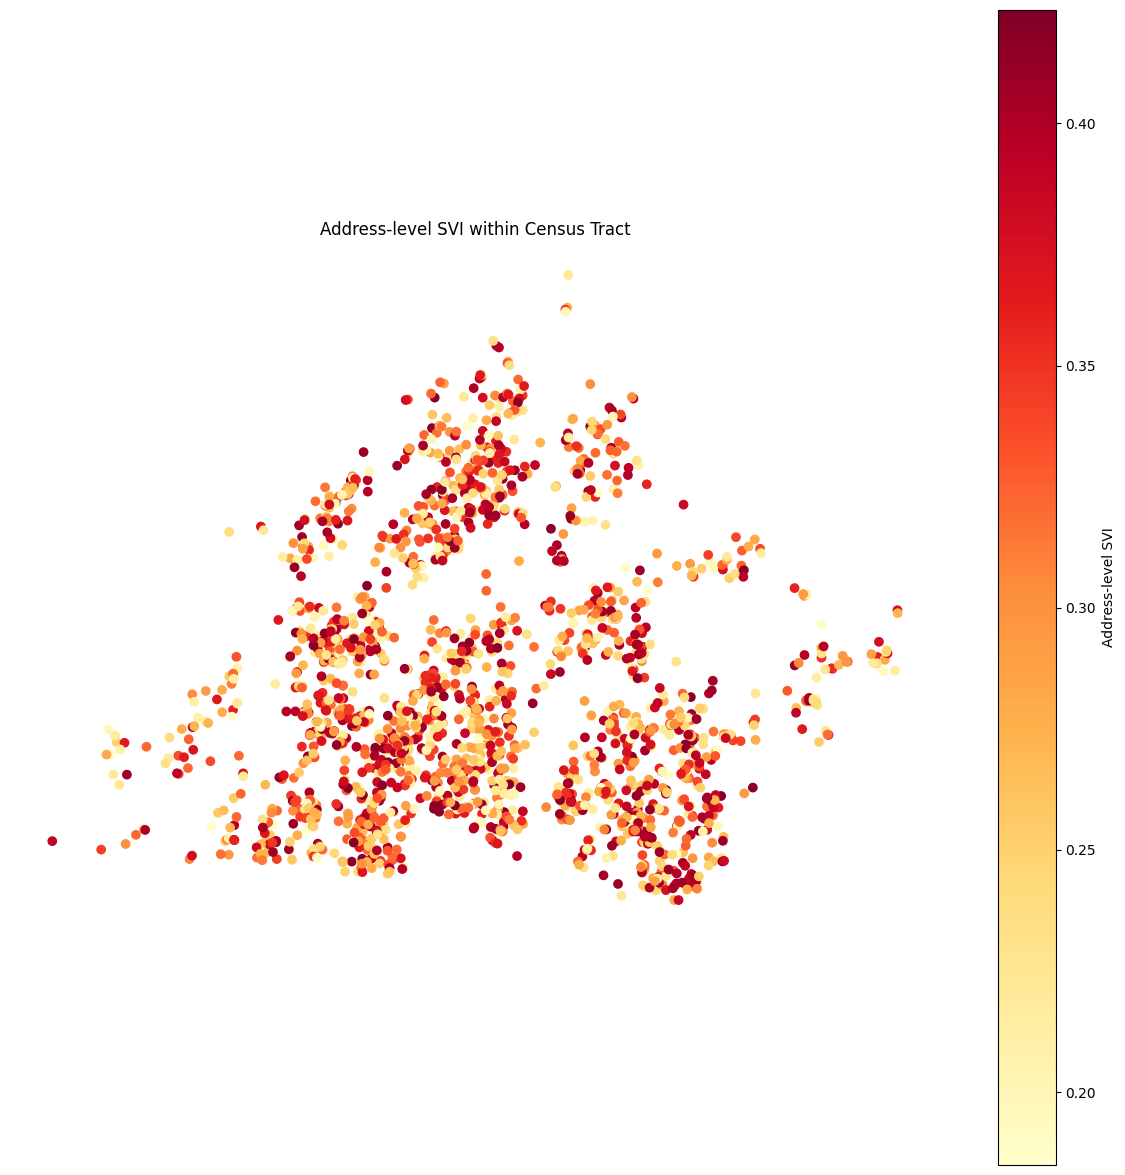

The mean SVI difference is: 0.06552348486882413


In [34]:
# Usage
summary_stats = validate_svi_results(result_df)

print(f"The mean SVI difference is: {summary_stats['mean']}")

### Visualization

In [35]:
def visualize_address_svi_with_roads(
    result_df: gpd.GeoDataFrame,
    roads_df: gpd.GeoDataFrame,
    target_area: str,
    svi_df: gpd.GeoDataFrame,
    output_file: str = None
):
    """
    Visualize address-level SVI with road network and census tracts.

    Parameters:
    -----------
    result_df : gpd.GeoDataFrame
        GeoDataFrame containing address-level SVI results.
    roads_df : gpd.GeoDataFrame
        GeoDataFrame containing road network data.
    target_area : str
        Identifier for the target census tract.
    svi_df : gpd.GeoDataFrame
        GeoDataFrame containing census tract data with SVI information.
    output_file : str, optional
        Path to save the output figure. If None, the plot will be displayed instead.
    """
    fig, ax = plt.subplots(figsize=(15, 15))

    # Plot the roads
    roads_df.plot(ax=ax, color='lightgray', linewidth=0.5, alpha=0.5)

    # Plot the address points, colored by SVI
    result_df.plot(column='address_level_svi',
                   cmap='YlOrRd',
                   legend=True,
                   ax=ax,
                   legend_kwds={'label': 'Address-level SVI'},
                   markersize=20)

    # Get the target tract and neighboring tracts
    target_tract = svi_df[svi_df['FIPS'] == target_area].iloc[0]
    neighboring_tracts = svi_df[svi_df.geometry.touches(target_tract.geometry)]
    tracts_to_plot = pd.concat([svi_df[svi_df['FIPS'] == target_area], neighboring_tracts])

    # Plot tract boundaries
    tracts_to_plot.boundary.plot(ax=ax, color='black', linewidth=1)

    # Highlight the target tract
    target_gdf = gpd.GeoDataFrame([target_tract], geometry='geometry')
    target_gdf.boundary.plot(ax=ax, color='red', linewidth=2)

    # Set the plot extent
    ax.set_xlim(tracts_to_plot.total_bounds[0], tracts_to_plot.total_bounds[2])
    ax.set_ylim(tracts_to_plot.total_bounds[1], tracts_to_plot.total_bounds[3])

    plt.title(f'Address-level SVI and Road Network in Census Tract {target_area}')
    plt.axis('off')
    plt.tight_layout()

    if output_file:
        plt.savefig(output_file, dpi=300, bbox_inches='tight')
        plt.close()
    else:
        plt.show()

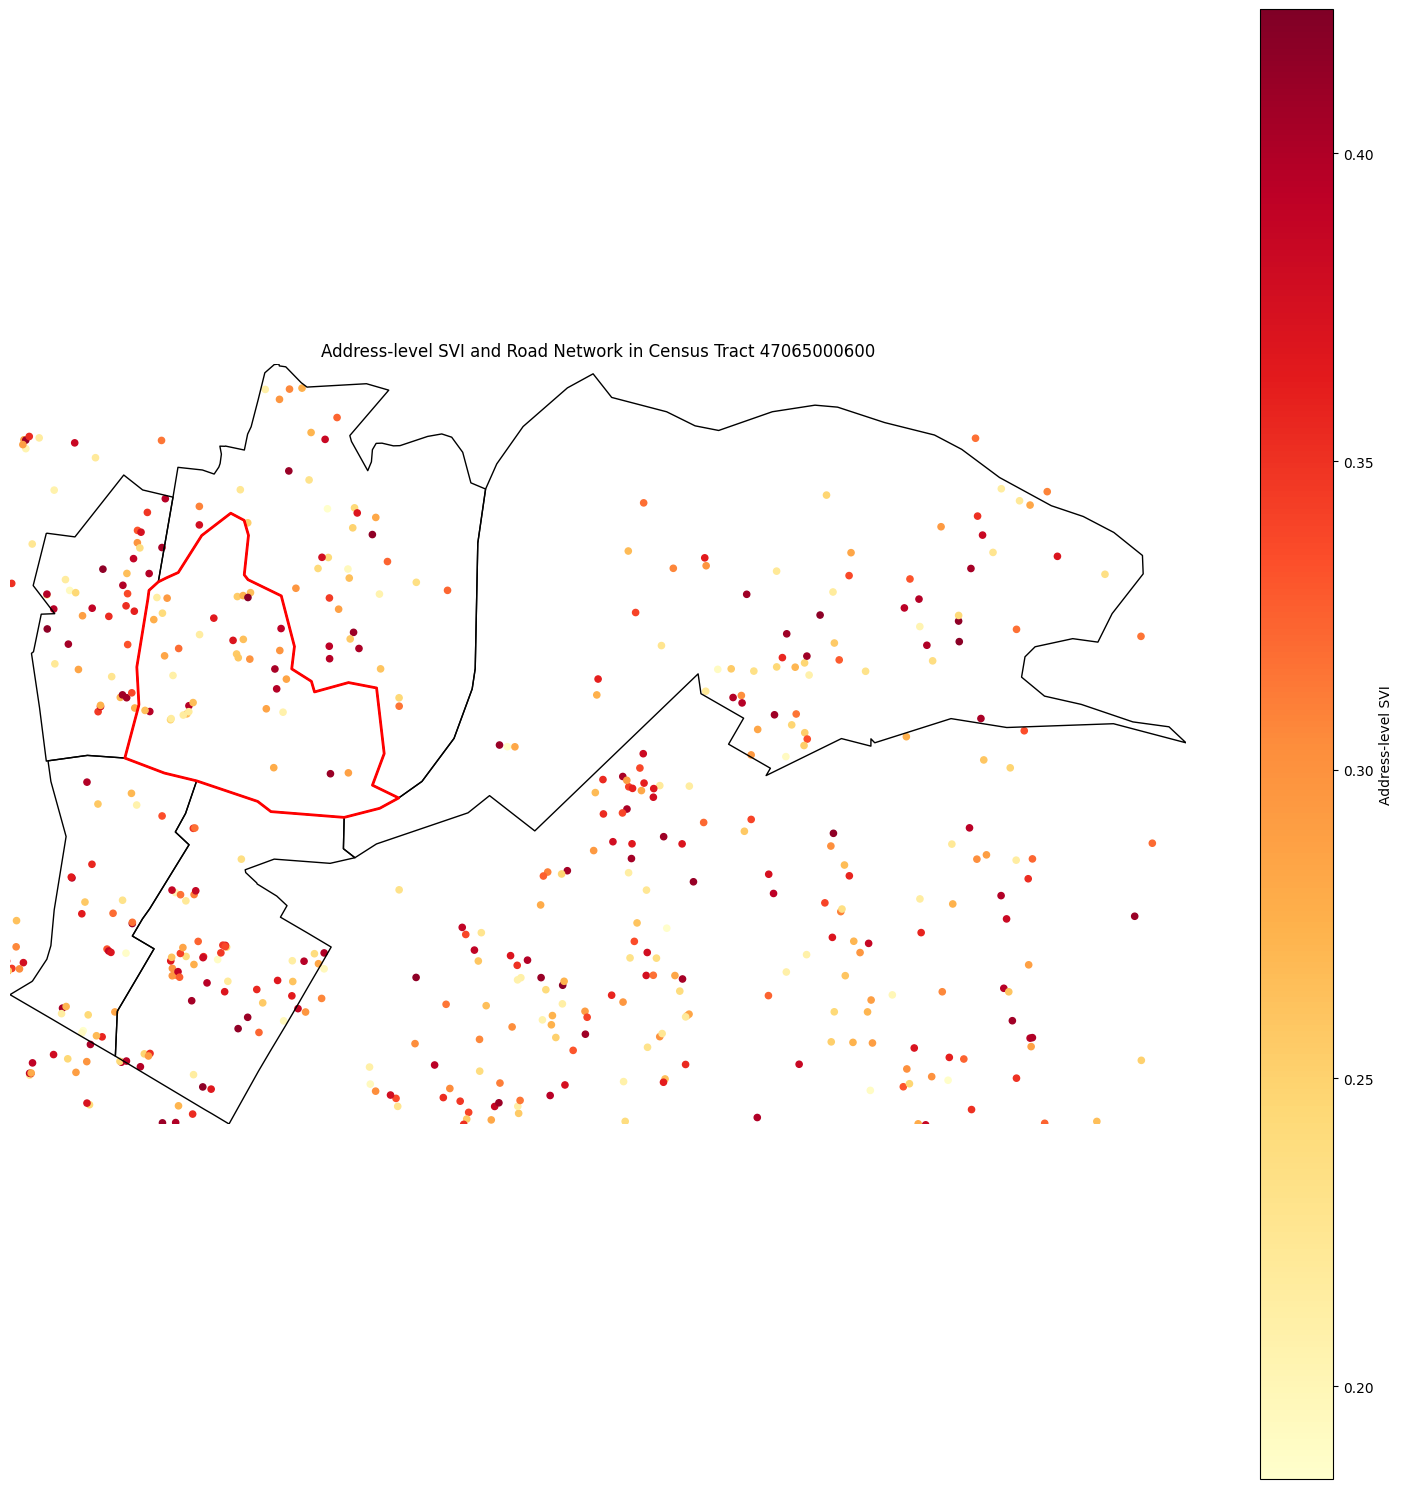

In [37]:
# Define the target area (census tract) to visualize
target_area = '47065000600'

# Call the visualization function
visualize_address_svi_with_roads(
    result_df=result_df,
    roads_df=roads_df,
    target_area=target_area,
    svi_df=svi_df
    #output_file='address_svi_with_roads_map.png'  # Optional: Remove this if you don't want to save the file
)

# FORMULAS

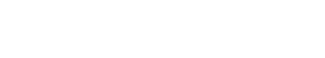

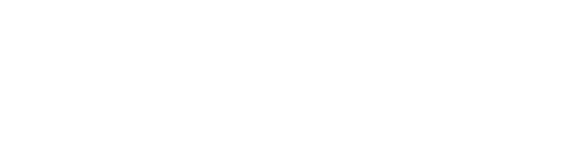

where...

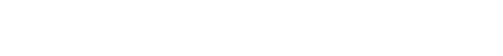

E_c(p,n): The combined inverse elasticity between point p and neighboring area n.

w: The network weight (between 0 and 1). It determines the balance between network and Euclidean distance in the calculation.

λ (lambda): The decay parameter. It controls how quickly the influence decreases with distance.

d_n(p,n): The network distance between point p and the nearest point in neighboring area n.

d_e(p,n): The Euclidean distance between point p and the nearest point in neighboring area n.

e: The mathematical constant e (approximately 2.71828), base of natural logarithms.

s_t: The index value (e.g., SVI) of the target area.

s_n: The index value (e.g., SVI) of the neighboring area n.

β (beta): The exponent for the index difference. It controls how sensitive the calculation is to differences in the index values.

|s_t - s_n|: The absolute difference between the index values of the target and neighboring areas.


\text{For each target area } t:
\begin{aligned}
  &\text{For each point } p \text{ in } t:\\
  &\quad\text{For each neighboring area } n:\\
  &\qquad E_e(p,n) = e^{-\lambda d_e(p,n)} / |s_t - s_n|^\beta &\quad&\text{(Euclidean inverse elasticity)}\\
  &\qquad E_n(p,n) = e^{-\lambda d_n(p,n)} / |s_t - s_n|^\beta &\quad&\text{(Network inverse elasticity)}\\
  &\qquad E_c(p,n) = w \cdot E_n(p,n) + (1 - w) \cdot E_e(p,n) &\quad&\text{(Combined inverse elasticity)}\\
  &\\
  &\quad W(p,n) = \frac{E_c(p,n)}{\sum_n E_c(p,n)} &\quad&\text{(Normalized weight)}\\
  &\quad s_p = s_t + \sum_n \left(W(p,n) \cdot (s_n - s_t)\right) &\quad&\text{(Weighted index for point }p\text{)}\\
  &\\
  &S_t = \frac{\sum_p s_p}{P} &\quad&\text{(Final weighted index for target area)}
\end{aligned}

\text{Where:}

\begin{aligned}

&d_e(p,n) \text{ is the Euclidean distance}\

&d_n(p,n) \text{ is the network distance}\

&\lambda \text{ is the decay parameter}\

&\beta \text{ is the exponent for index difference sensitivity}\

&w \text{ is the network weight}\

&s_t \text{ is the index value of the target area}\

&s_n \text{ is the index value of the neighboring area}\

&P \text{ is the total number of points in the target area}

\end{aligned}

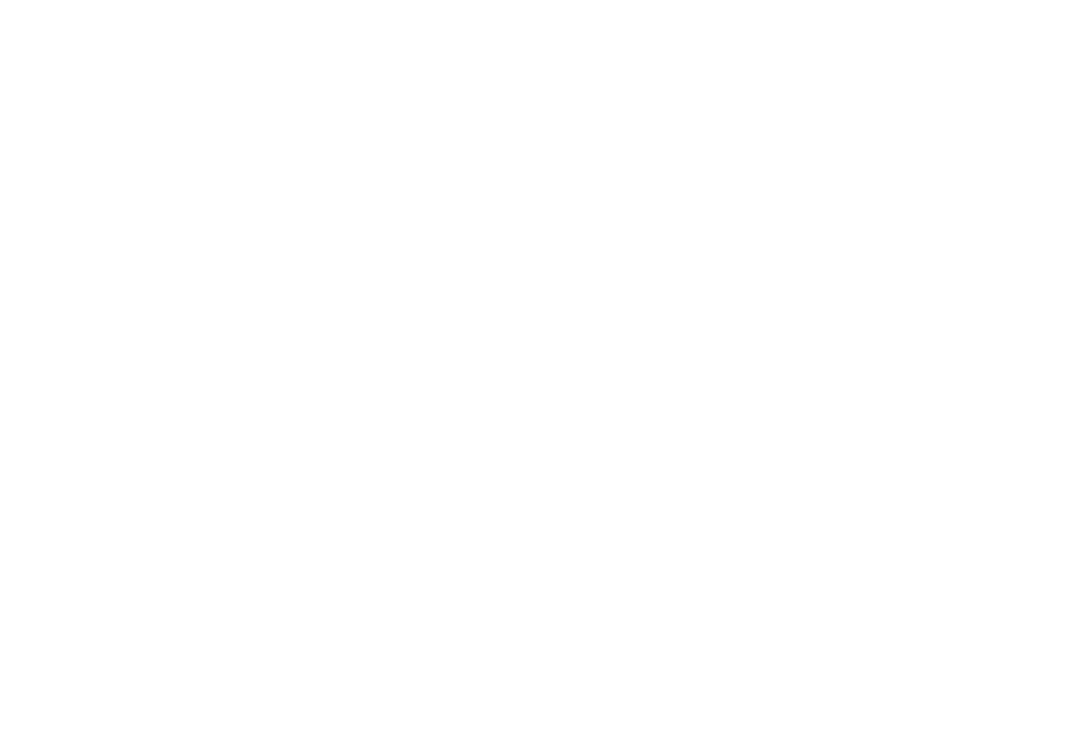